Import dependencies

In [1]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T # for later data augmentation
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM

In [12]:
# for better visualization during preprocessing, we view tensors and PIL images
t2img = T.ToPILImage() # tensor to pil image
img2t = T.ToTensor() # pil image to tensor

In [3]:
# check if we have gpu
print(f"Cuda: {torch.cuda.is_available()}")

Cuda: False


In [4]:
# use the same working direction as defined in the tools script
from utils_pets import working_dir

# import all the helper functions
from utils_pets import save_model_checkpoint, get_device, load_model_from_checkpoint, to_device, get_model_parameters, print_model_parameters, close_figures

# Data Preparation and Preprocessing

Load the Oxford IIIT Pets dataset with torchvision

In [5]:
# define the dataset paths
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
# load the dataset
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=False)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=False)

In [8]:
## see the values in the ground truth masks
# take one training example
pets_train_orig[0]

(<PIL.Image.Image image mode=RGB size=394x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=394x500>)

In [13]:
img2t(pets_train_orig[0][1])

tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]]])

We observe that they are values in [0,1]. We need to convert to integers to simplify the training.

We can also see that the values in integer are {1,2,3}. We want to convert it to {0,1,2}. and the most common is 2, which is the background index.

In [17]:
np.unique(img2t(pets_train_orig[0][1]) * 255, return_counts=True)

(array([1., 2., 3.], dtype=float32),
 array([ 52806, 114847,  29347], dtype=int64))

In [18]:
# for later use, there are only 3 classes
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

In [19]:
# for display usage, we need all three values in between 0 and 1, and should be floats
def trimap2f(trimap): # taking in a PIL image
    return (img2t(trimap) * 255 - 1)/2

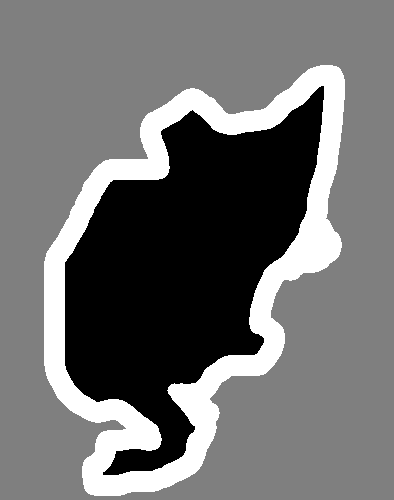

In [23]:
# try to display the mask
t2img(trimap2f(pets_train_orig[0][1]))

In [24]:
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"


In [25]:
# we need to use data augmentation, therefore we need to define a new class to inherit the dataset function
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(self,
                 root: str, # original param, Root directory of the dataset
                 split: str, # original param, The dataset split, supports "trainval" (default) or "test"
                 target_types = "segmentation",
                 download = False,
                 pre_transform = None,
                 pre_target_transform = None,
                 post_transform = None,
                 post_target_transform = None,
                 common_transform = None
                 ):
        super().__init__(
            root = root,
            split = split,
            target_types = target_types,
            download = download,
            transform = pre_transform,
            target_transform = pre_target_transform
        )
        self.common_transform = common_transform
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        # here we apply the transforms before returning the input and target
        (input, target) = super().__getitem__(idx) # first we perform pre_transform and pre_target_transform as in the parent class
        if self.common_transform is not None: # if we have to provide common transform on input and target, concate the two, transform together and then separate them
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim = 0)
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)
        return (input, target)

Our pretransform is usually making the PIL to tensor.

For post transform, for the target, we need to make them into trimap. For input images, we need to apply color jitter to augment the image contrast, hue etc.

For common transform, it is usually random horizontal flip, resize etc. For resizing, we need interpolation algorithm clarified.

In [26]:
# define a post target transform from normal tensor to images
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long) # we need to transform it to integers
    x = x - 1
    return x

In [27]:
# make the input parameters to form a dictionary
def args_to_dic(**kwargs):
    return kwargs

In [28]:
# define our data transformation
transform_dict = args_to_dic(
    pre_transform = T.ToTensor(),
    pre_target_transform = T.ToTensor(),
    common_transform = T.Compose([ToDevice(get_device()),
                                  T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
                                  T.RandomHorizontalFlip(p=0.5)]),
    post_transform = T.Compose([
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform = T.Compose([T.Lambda(tensor_trimap)],),
)

In [29]:
# create the augmented dataset from the original dataset
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

[DataLoader in Torch](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [37]:
# put the dataset into a data loader
pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size = 64,
    shuffle = True,
)

pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size = 21,
    shuffle = True,
)

In [38]:
# iterate once throught the dataloader to check if it works
(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))

In [80]:
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))

In [40]:
train_pets_inputs.size() # we can see that it is a batch

torch.Size([64, 3, 128, 128])

In [41]:
np.unique(train_pets_targets) # check if our data augmentation has done

array([0, 1, 2], dtype=int64)

check the images and a batch

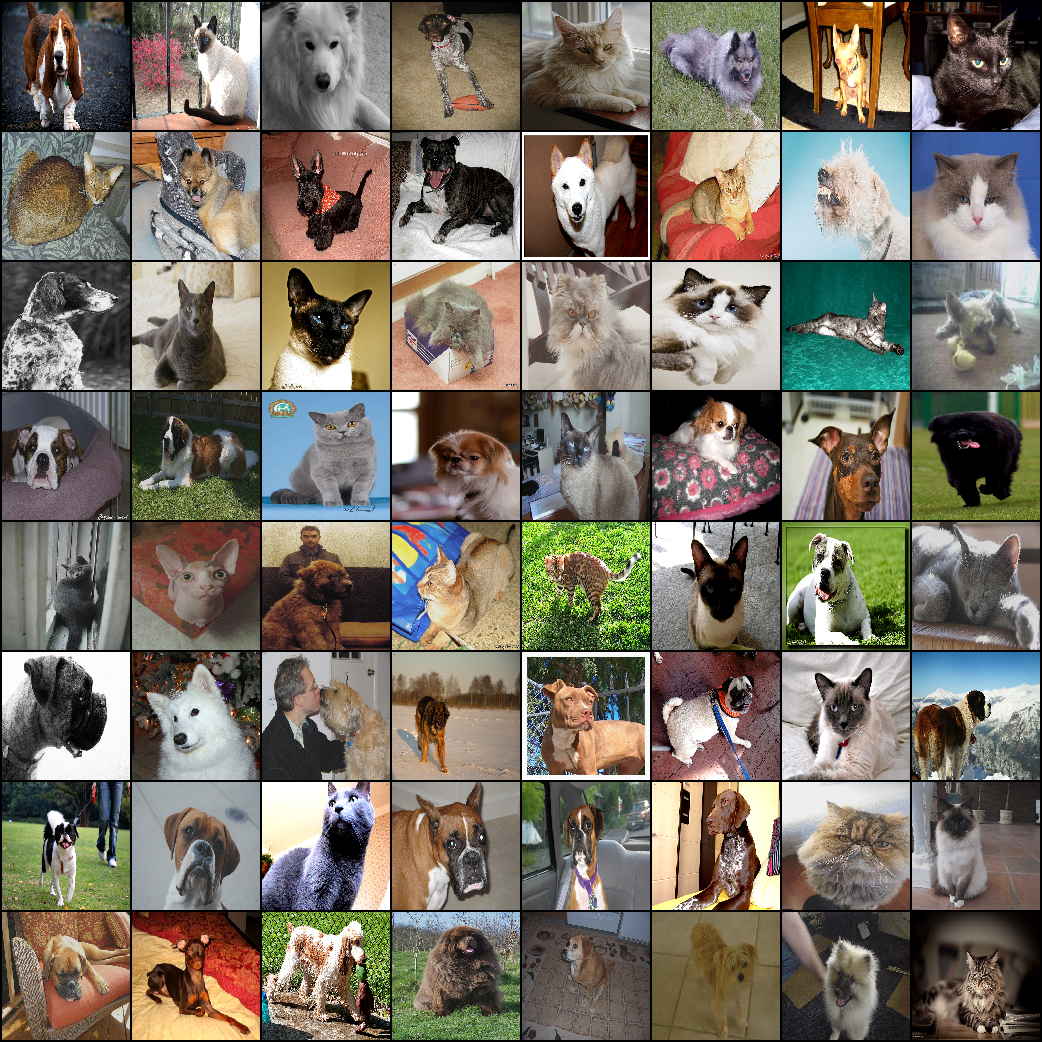

In [43]:
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

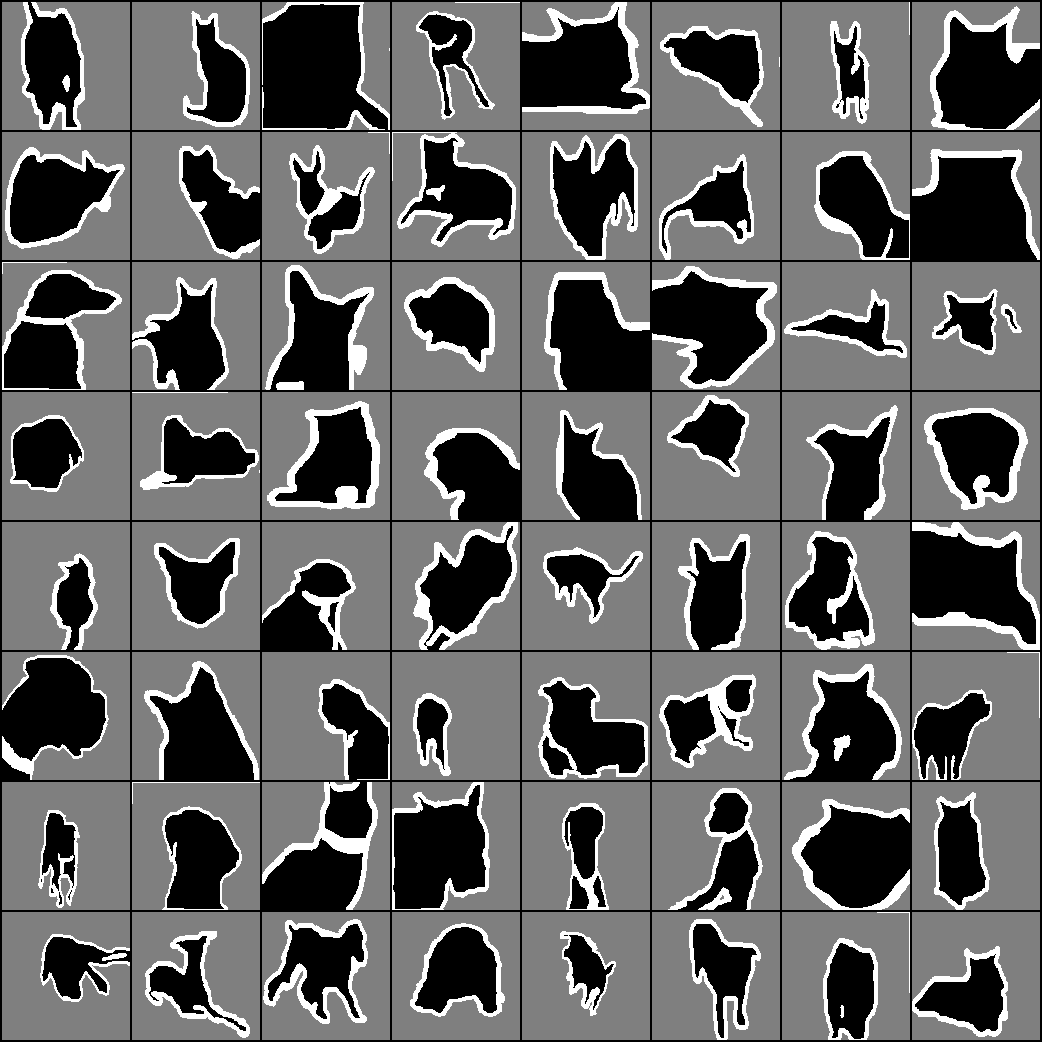

In [44]:
pets_target_grid = torchvision.utils.make_grid(train_pets_targets/2.0, nrow=8)
t2img(pets_target_grid)

# Model Definition: Basic SegNet Model

We first define each block in the SegNet, demonstrated in the article [SegNet Explained](https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-2-bed68cadd7c7)


Encoder part:
- Two layer structure: 2 * Conv+BatchNorm+ReLu + MaxPooling

- Three layer structure: 3 * Conv+BatchNorm+ReLu + MaxPooling

- Remembering the maxpooling indices

In [68]:
class DownConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2,bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout,kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        # max pooling layer,  returning the output and pooling indices to use later
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

class DownConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=kernel_size, padding=kernel_size//2,bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout,kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
            nn.Conv2d(in_channels=chout, out_channels=chout,kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        # max pooling layer,  returning the output and pooling indices to use later
        self.mp = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.mp(y)
        return y, indices, pool_shape

Decoder part:
- Two layer structure: MaxUnPool + 2 * Conv+BatchNorm+ReLu

- Three layer structure: MaxUnPool + 3 * Conv+BatchNorm+ReLu

- Use the maxpooling indices and shape in forward from the encoder part

[MaxUnpool documentation](https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html)

In [69]:
class UpConv2(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2,bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout,kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y

class UpConv3(nn.Module):
    def __init__(self, chin, chout, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2,bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chin, kernel_size=kernel_size, padding=kernel_size//2,bias=False),
            nn.BatchNorm2d(chin),
            nn.ReLU(),
            nn.Conv2d(in_channels=chin, out_channels=chout,kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(chout),
            nn.ReLU(),
        )
        self.mup = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.mup(x, indices, output_size=output_size)
        y = self.seq(y)
        return y

Put them together for SegNet

In [70]:
class ImageSegmentation(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.out_channels = 3 # probability for each class
        # there's no input normalization, instead a batch norm at the beginning
        self.bn_input = nn.BatchNorm2d(3) # 3 RGB channels
        self.dc1 = DownConv2(3, 64, kernel_size=kernel_size)
        self.dc2 = DownConv2(64, 128, kernel_size=kernel_size)
        self.dc3 = DownConv3(128, 256, kernel_size=kernel_size)
        self.dc4 = DownConv3(256, 512, kernel_size=kernel_size)
        # self.dc5 = DownConv3(512, 512, kernel_size=kernel_size) # low resolution so we don't use this

        # self.uc5 = UpConv3(512, 512, kernel_size=kernel_size)
        self.uc4 = UpConv3(512, 256, kernel_size=kernel_size)
        self.uc3 = UpConv3(256, 128, kernel_size=kernel_size)
        self.uc2 = UpConv3(128, 64, kernel_size=kernel_size)
        self.uc1 = UpConv3(64, 3, kernel_size=kernel_size)

    def forward(self, batch: torch.Tensor): # input is a batch
        x = self.bn_input(batch) # first a batchnorm layer
        x, mp1_indices, shape1 = self.dc1(x)
        x, mp2_indices, shape2 = self.dc2(x)
        x, mp3_indices, shape3 = self.dc3(x)
        x, mp4_indices, shape4 = self.dc4(x)
        # x, mp5_indices, shape5 = self.dc5(x)

        # x = self.uc5(x, mp5_indices, output_size=shape5)
        x = self.uc4(x, mp4_indices, output_size=shape4)
        x = self.uc3(x, mp3_indices, output_size=shape3)
        x = self.uc2(x, mp2_indices, output_size=shape2)
        x = self.uc1(x, mp1_indices, output_size=shape1)

        return x

In [71]:
# run once the model to ensure there is no internal bug
m = ImageSegmentation(kernel_size=3) # dk = 3 convolution
m.eval()
to_device(m)
m(to_device(train_pets_inputs)).shape # input the first batch to test

torch.Size([64, 3, 128, 128])

# Loss Functions used in Training

## Why use softmax in IoU for segmentation? (GPT4 answer)
Using one-hot encoding to represent the maximum probability class for predictions (also known as "hard" predictions) versus using softmax probabilities (which result in "soft" predictions) depends on the context and objectives of the task. Both approaches have their advantages and disadvantages in different situations. Here's a comparison and explanation of why softmax is often preferred, especially for calculating metrics like Intersection over Union (IoU) in segmentation tasks:

### One-hot Encoding for Predictions:
- Advantages:
    - Produces discrete class assignments, making it straightforward to compare predictions directly against one-hot encoded ground truth.
    - Simplifies the evaluation of accuracy and other metrics that rely on direct class comparisons.
- Disadvantages:
    - Loses information about the model's confidence in its predictions. All incorrect predictions are treated equally, regardless of whether they were nearly correct or completely off.
    - Can lead to harsher penalties during training, as the gradient with respect to the model's parameters cannot differentiate between "close" and "far" incorrect predictions.
    - Not differentiable, making it unsuitable for use in loss functions that require gradient-based optimization.

### Softmax Probabilities:
- Advantages:
    - Retains information about the model's confidence across all classes, providing a richer signal for both evaluation and optimization.
    - Differentiable, allowing for the computation of gradients for optimization during training.
    - Soft predictions enable the calculation of more nuanced metrics and loss functions, such as cross-entropy loss, which directly uses the softmax probabilities.

- Disadvantages:
    - Requires additional steps to convert probabilities to class labels for some metrics and interpretations.
    - Might seem less intuitive for direct comparison against one-hot encoded ground truth in evaluation metrics that expect discrete class labels.

### Contextual Choice:
In many machine learning tasks, especially in classification, softmax is used in the model's output layer to produce a probability distribution across classes. This is because during training, the objective is often to minimize a loss function like cross-entropy, which benefits from having a differentiable function that provides a gradient signal.

For evaluation metrics like IoU, especially in segmentation tasks, using softmax probabilities allows for a "soft" comparison between predicted probabilities and the ground truth. This can be more informative as it considers the model's confidence across all classes rather than just its top choice. It's also useful in tasks where the boundaries between classes are not always clear-cut, and a soft measurement can provide a more nuanced assessment of the model's performance.

However, for certain metrics or when making final decisions, predictions might be converted to a one-hot format (or equivalent discrete class labels) post-softmax to compare directly against ground truth labels.

In summary, the choice between using one-hot encoding for predictions or softmax probabilities often comes down to the specific requirements of the task, the nature of the evaluation metrics, and the objectives of the training process. Softmax provides a nuanced view suitable for training and evaluating probabilistic models, while one-hot encoded predictions are used for discrete evaluations and decisions.






In [75]:
# intersection over union metric with softmax
def IoUMetric(pred, gt, softmax=False):
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)

    # create one hot encoding for gt, so that gt and pred are of same dimension
    gt = torch.cat([(gt==i) for i in range(3)], dim=1)

    intersection = gt * pred
    union = gt + pred - intersection

    # compute the iou for all dimension, except dim=0 which is the batch
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)

    # return the batch mean iou
    return iou.mean()

class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax

    def forward(self, pred, gt):
        return - (IoUMetric(pred, gt, self.softmax).log())

custom existing IoU documentation [TM.classification.MulticlassJaccardIndex](https://lightning.ai/docs/torchmetrics/stable/classification/jaccard_index.html)

# Model Training functions

In [76]:
# training of one epoch
def train_model(model, loader, optimizer):
    to_device(model.train()) # move the model to the device
    cel = True # if we use cross entropy loss
    if cel:
        criterion = nn.CrossEntropyLoss(reduction='mean') # the mean loss over batch
    else:
        criterion = IoULoss(softmax=True)

    # initialization
    running_loss = 0.0
    running_samples = 0

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        # iterate through the batches
        optimizer.zero_grad() # initialize the gradient of the optimizer
        inputs = to_device(inputs)
        targets = to_device(targets)
        outputs = model(inputs)

        if cel:
            targets = targets.squeeze(dim = 1) # remove the channel
            # you are effectively removing the channel dimension (C), transforming the shape from [N, 1, H, W] to [N, H, W].
        loss = criterion(outputs, targets)
        loss.backward() # back propagation
        optimizer.step() # update the model parameters according to the back propagation result

        running_samples += targets.size(0) # the numbers of image trained
        running_loss += loss.item() # extracts the scalar from the single dimension tensor, which is the loss over this batch
    print("Trained {} samples, Loss:{:,4f}".format(running_samples, running_loss/(batch_idx+1)))

## Helper functions on the test dataset

In [77]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel() # numel: total number of elements

def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
    to_device(model.eval()) # the targets are images
    predictions = model(to_device(test_pets_targets))
    test_pets_labels = to_device(test_pets_labels) # the gt
    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions) # get the logits

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)

    # accuracy = prediction_accuracy(test_pets_labels, pred_labels)
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    custom_iou = IoUMetric(pred, test_pets_labels)
    title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
    print(title)
    # print(f"Accuracy: {accuracy:.4f}")

    # Close all previously open figures.
    close_figures()

    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7))) # show the images
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")

    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)
    # end if

    if show_plot is False:
        close_figures()
    else:
        plt.show()
    # end if
# end def

In [78]:
def test_dataset_accuracy(model, loader):
    to_device(model.eval())
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))

    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []

    print_model_parameters(model)

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        # Add a value 1 dimension at dim=1
        pred_labels = pred_labels.unsqueeze(1)
        # print("pred_labels.shape: {}".format(pred_labels.shape))
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        # pixel_accuracy = pixel_metric(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())

        del inputs
        del targets
        del predictions
    # end for

    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)

    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")

Epoch: 00, Accuracy[Pixel: 0.2665, IoU: 0.5222, Custom IoU: 0.2000]


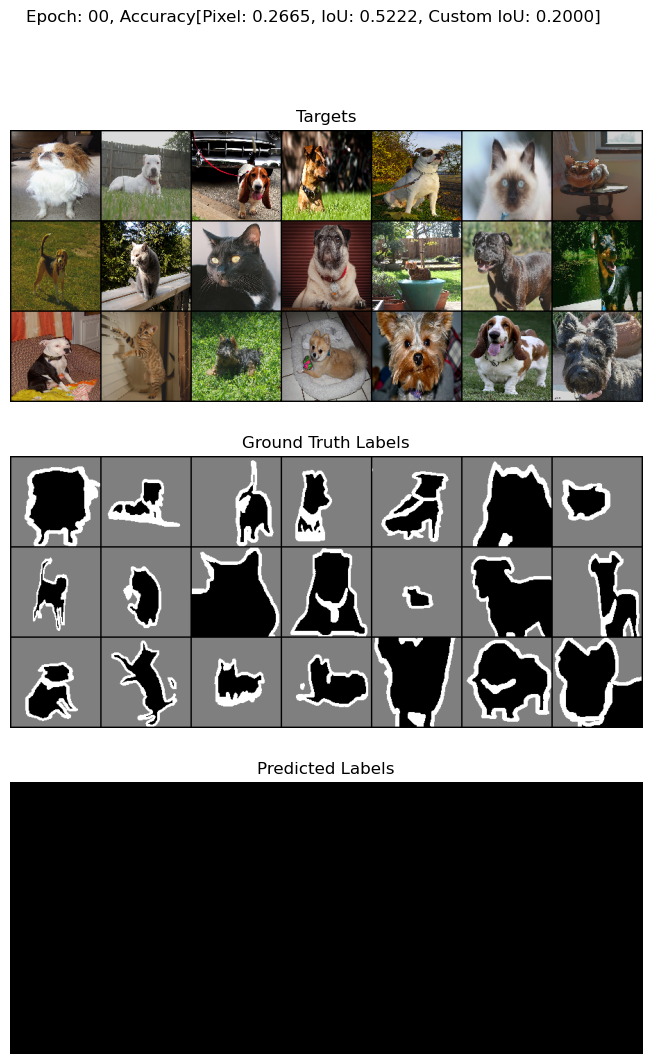

In [81]:
# Check if our helper functions work as expected and if the image
# is generated as expected.
save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
os.makedirs(save_path, exist_ok=True)
print_test_dataset_masks(m, test_pets_inputs, test_pets_targets, epoch=0, save_path=None, show_plot=True)

# Model Training

In [82]:
# Optimizer and Learning Rate Scheduler.
to_device(m)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

In [83]:
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path):
    """
    :param model: pre-defined model for this task
    :param loader: dataloader (training data)
    :param test_data: one batch of test data: ex. (test_pets_inputs, test_pets_targets)
    :param epochs: an interval, ex. [1,21]
    :param optimizer: pre-defined optimizer
    :param scheduler: pre-defined lr scheduler
    :param save_path: save path of checkpoints and images
    :return:
    """
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs # the starting and ending training epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        with torch.inference_mode():
            # Display the plt in the final training epoch.
            print_test_dataset_masks(model, test_inputs, test_targets, epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1))
        if scheduler is not None:
            scheduler.step()
        print("")

In [ ]:
save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
train_loop(m, pets_train_loader, (test_pets_inputs, test_pets_targets), (1, 21), optimizer, scheduler, save_path)